https://github.com/huggingface/peft/blob/main/examples/fp4_finetuning/finetune_fp4_opt_bnb_peft.py

In [1]:
from torch import optim
import lightning as pl
from matplotlib import pyplot as plt

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from loguru import logger
import sys

# only if you want it shorter
logger.remove()
logger.add(sys.stderr, format="<level>{message}</level>", level="WARNING")

1

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import warnings
from peft import LoraConfig, get_peft_model, IA3Config

In [4]:
plt.style.use('seaborn-v0_8')
torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*Was asked to gather along dimension 0.*")
warnings.filterwarnings("ignore", ".*There is an imbalance between your GPUs.*")

In [5]:
# model_name = "TheBloke/phi-2-GPTQ"
model_name = "microsoft/phi-2"

# https://huggingface.co/collections/unsloth/llama-32-66f46afde4ca573864321a22
model_name = "unsloth/Llama-3.2-1B"
model_name = "unsloth/Llama-3.2-1B-bnb-4bit"
# Model Release Date: Sept 25, 2024
# launch date 9/25/2024 https://github.com/meta-llama/llama-models/blob/main/README.md
# https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing
# unsloth/Llama-3.2-3B
# Data Freshness: The pretraining data has a cutoff of December 2023.

def load_model():

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # quantization_config=BitsAndBytesConfig(
        #     load_in_4bit=True,
        #     llm_int8_threshold=6.0,
        #     llm_int8_has_fp16_weight=False,
        #     bnb_4bit_compute_dtype=torch.float16,
        #     bnb_4bit_use_double_quant=True,
        #     bnb_4bit_quant_type="nf4",
        # ),
        torch_dtype=torch.float16,
        trust_remote_code=True,
    )


    # config = AutoConfig.from_pretrained(model_name, trust_remote_code=True,)
    # config.quantization_config['use_exllama'] = False
    # config.quantization_config['disable_exllama'] = True
    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name,
    #     torch_dtype=torch.bfloat16,
    #     trust_remote_code=True,
    #     config=config,
    # )
    return model


In [6]:
base_model = load_model()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def reset_model(base_model):
    # peft_config = LoraConfig(
    #     # task_type=TaskType.TOKEN_CLS, 
    #     target_modules=[ "fc2",  "Wqkv",],
    #     inference_mode=False, r=4, lora_alpha=4, 
    #     # lora_dropout=0.1, 
    #     # bias="all"
    # )
    # peft_config = IA3Config(
    #     target_modules=[ "fc2",  "Wqkv",], 
    #         feedforward_modules=["fc2"],
    #         inference_mode=False,
    # )
    peft_config = IA3Config(
        # target_modules=[ "fc2",  "Wqkv", 'out_proj', 'fc1'], 
        #     feedforward_modules=["fc2", 'fc1', 'out_proj'],
        #     inference_mode=False,
    )
    model = get_peft_model(base_model, peft_config)
    model.config.use_cache = False
    return model

model = reset_model(base_model)

In [8]:

MAX_LEN = 400

import frontmatter
from pathlib import Path
sample_files = sorted(Path("../samples/").glob('*.md'))
print(sample_files)
samples = [{'f':f, **frontmatter.load(f).to_dict()} for f in sample_files]

for sample in samples:
    assert 'title' in sample, sample['f']
    assert 'content' in sample
samples[0].keys()

[PosixPath('../samples/bletchley_decleration.md'), PosixPath('../samples/cicero_fin1.md'), PosixPath('../samples/disney_appointment.md'), PosixPath('../samples/fake_paper.md'), PosixPath('../samples/fauci_emails.md'), PosixPath('../samples/harvard_announcement_reminders.md'), PosixPath('../samples/how_to_catch_a_liar.md'), PosixPath('../samples/lk-99_end.md'), PosixPath('../samples/lk-99_espanol.md'), PosixPath('../samples/lorem_ipsum.md'), PosixPath('../samples/openai_board_ann.md'), PosixPath('../samples/openai_paper_weak_to_strong.md'), PosixPath('../samples/politics_is_the_mind_killer.md'), PosixPath('../samples/statement_vyKamala_on_passing_of_johnson.md'), PosixPath('../samples/survey_of_rumours.md')]


dict_keys(['f', 'title', 'url', 'content'])

## Helpers

In [9]:
# modified from https://github.dev/huggingface/evaluate/blob/8dfe05784099fb9af55b8e77793205a3b7c86465/measurements/perplexity/perplexity.py#L154
import evaluate
from evaluate import logging
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

def perplexity_compute(
    ds, model, tokenizer, batch_size: int = 16, add_start_token: bool = True, device=None, max_length=None
):
    model = model.to(device)


    ds = ds.with_format('pt')
    dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=tokenizer.pad, pin_memory=True)
    ppls = []
    loss_fct = CrossEntropyLoss(reduction="none")
    for b in dl:
        input_ids = b['input_ids'].to(device)
        attention_mask = b['attention_mask'].to(device)
        # print(attention_mask)

        labels = input_ids

        with torch.no_grad():
            out_logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_attention_mask_batch = attention_mask[..., 1:].contiguous()

        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch).sum(1)
            / shift_attention_mask_batch.sum(1)
        )

        ppls += perplexity_batch.tolist()

    return {"perplexities": ppls, "mean_perplexity": torch.tensor(ppls).mean()}

In [10]:
# perplexity_compute(ds=ds_val, model=model, tokenizer=tokenizer, device='cuda')

## Training

In [11]:
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from datasets import Dataset

## Lightning helpers

In [12]:
def eval(model, tokenizer, ds_val: Dataset):
    model.eval();
    with torch.no_grad():
        with model.disable_adapter():
            results = perplexity_compute(ds=ds_val, model=model, tokenizer=tokenizer, device='cuda')
        results2 = perplexity_compute(ds=ds_val, model=model, tokenizer=tokenizer, device='cuda')
    return dict(before=results['mean_perplexity'].item(), after=results2['mean_perplexity'].item())


# Train

In [13]:
from datasets import Dataset


def compute_metrics(eval_prediction):
    return {}

Trainer docs

- https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer

In [14]:
MAX_LEN, len(sample['content'])//3

(400, 14201)

In [15]:
from sklearn.model_selection import train_test_split

def tokenize_and_split(examples):
    l = len(tokenizer(examples).input_ids[0])
    max_len = min(l//3, MAX_LEN) # break into at least 5
    max_len = max(max_len, 10)


    result = tokenizer(
        examples,
        add_special_tokens=False,
        truncation=True,
        stride=2,
        max_length=max_len,
        return_overflowing_tokens=True,
        return_attention_mask=True,
    )
    return result

s = sample['content']
d = Dataset.from_dict(tokenize_and_split([s]))
d2  = d.train_test_split(test_size=0.5, seed=42)
ds_train = d2['train']
ds_val = d2['test']
ds_val

Token indices sequence length is longer than the specified maximum sequence length for this model (8172 > 2048). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
    num_rows: 11
})

In [16]:
def learn_sample(sample):
    # device = 'cuda'
    # lr = 4e-3
    # epochs = 3
    # accum_steps = 1
    batch_size = 1
    verbose = False

    s = sample['content']

    d = Dataset.from_dict(tokenize_and_split([s]))
    d2  = d.train_test_split(test_size=0.5, seed=42)
    ds_train = d2['train']
    ds_val = d2['test']

    
    model = reset_model(base_model)
    # eval(model, tokenizer, ds_train)

    # https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer
    trainer = transformers.Trainer(
        model=model,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        compute_metrics=compute_metrics, # without this it wont even give val loss
        args=transformers.TrainingArguments(
            # checkpoint='epoch',
            save_strategy='epoch',
            label_names=['labels',],
            per_device_train_batch_size=batch_size,
            # gradient_accumulation_steps=1,
            # warmup_steps=6,
            warmup_ratio=0.1,
            # max_steps=50,
            num_train_epochs=3,
            learning_rate=1e-3,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            log_level='error',
            # do_eval=True,
            evaluation_strategy="epoch",
            eval_steps=1,
            load_best_model_at_end=True,
            
            # disable_tqdm=not verbose,
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )
    trainer._signature_columns = ['input_ids', 'attention_mask', 'labels',]
    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    train_output = trainer.train()

    df_hist = pd.DataFrame(trainer.state.log_history)
    df_hist_epoch = df_hist.groupby('epoch').last().drop(columns=['step'])
    df_hist_step = df_hist.set_index('step').dropna(thresh=2, axis=1)
    if verbose:
        df_hist_epoch['loss'].plot()
        plt.twinx()
        df_hist_epoch['eval_loss'].plot(c='b', label='eval')
        plt.legend()
        plt.show()


    result_train = {f'train/{k}':v for k,v in eval(model, tokenizer, ds_train).items()}
    result = eval(model, tokenizer, ds_val)
    result['hist'] = df_hist_epoch
    result.update(result_train)
    return result


In [17]:
data = []
for sample in samples:
    r = learn_sample(sample)
    print(sample['title'])
    print(dict(before=r['before'], after=r['after']))
    data.append(dict(**r, **sample))

 17%|█▋        | 1/6 [00:00<00:02,  2.35it/s]

{'loss': 2.8049, 'learning_rate': 0.001, 'epoch': 0.5}


 33%|███▎      | 2/6 [00:00<00:01,  2.80it/s]

{'loss': 2.3359, 'learning_rate': 0.0008, 'epoch': 1.0}


                                             
 33%|███▎      | 2/6 [00:00<00:01,  2.80it/s]

{'eval_loss': 2.8958373069763184, 'eval_runtime': 0.2605, 'eval_samples_per_second': 7.677, 'eval_steps_per_second': 3.839, 'epoch': 1.0}


 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

{'loss': 2.7644, 'learning_rate': 0.0006, 'epoch': 1.5}


 67%|██████▋   | 4/6 [00:01<00:00,  2.42it/s]

{'loss': 2.297, 'learning_rate': 0.0004, 'epoch': 2.0}


                                             
 67%|██████▋   | 4/6 [00:01<00:00,  2.42it/s]

{'eval_loss': 2.8877780437469482, 'eval_runtime': 0.2592, 'eval_samples_per_second': 7.715, 'eval_steps_per_second': 3.857, 'epoch': 2.0}


 83%|████████▎ | 5/6 [00:02<00:00,  2.05it/s]

{'loss': 2.2516, 'learning_rate': 0.0002, 'epoch': 2.5}


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

{'loss': 2.6997, 'learning_rate': 0.0, 'epoch': 3.0}


                                             
100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


{'eval_loss': 2.884704113006592, 'eval_runtime': 0.2598, 'eval_samples_per_second': 7.699, 'eval_steps_per_second': 3.85, 'epoch': 3.0}
{'train_runtime': 2.9316, 'train_samples_per_second': 2.047, 'train_steps_per_second': 2.047, 'train_loss': 2.525577942530314, 'epoch': 3.0}
blechley declaration
{'before': 17.869091033935547, 'after': 17.52420425415039}
{'loss': 4.625, 'learning_rate': 0.0005, 'epoch': 0.17}
{'loss': 4.5422, 'learning_rate': 0.001, 'epoch': 0.33}
{'loss': 4.5928, 'learning_rate': 0.0009375, 'epoch': 0.5}
{'loss': 4.5384, 'learning_rate': 0.000875, 'epoch': 0.67}
{'loss': 4.7047, 'learning_rate': 0.0008125000000000001, 'epoch': 0.83}
{'loss': 4.4394, 'learning_rate': 0.00075, 'epoch': 1.0}
{'eval_loss': 4.234132289886475, 'eval_runtime': 0.8515, 'eval_samples_per_second': 7.047, 'eval_steps_per_second': 1.174, 'epoch': 1.0}
{'loss': 4.4981, 'learning_rate': 0.0006875, 'epoch': 1.17}
{'loss': 4.5187, 'learning_rate': 0.000625, 'epoch': 1.33}
{'loss': 4.419, 'learning_ra

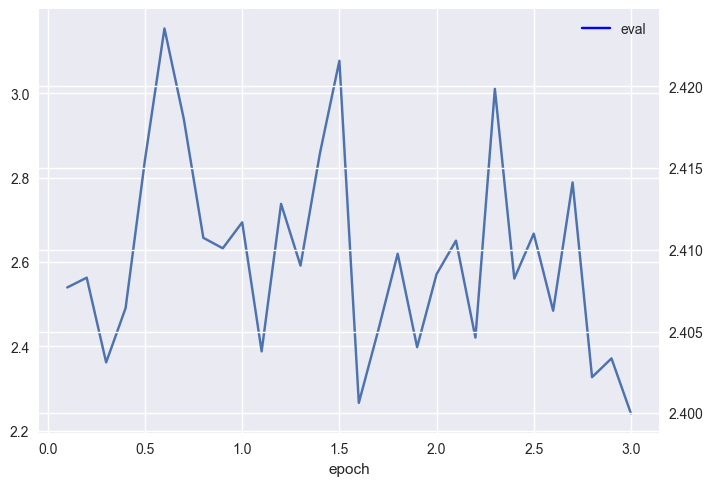

In [18]:
# example training
df_hist = data[-1]['hist']#.groupby('epoch').last().dropna(axis=1).drop(columns=['step'])
df_hist['loss'].plot(label='train')
plt.twinx()
df_hist['eval_loss'].plot(c='b', label='eval')
plt.legend()
plt.show()

<Axes: xlabel='epoch'>

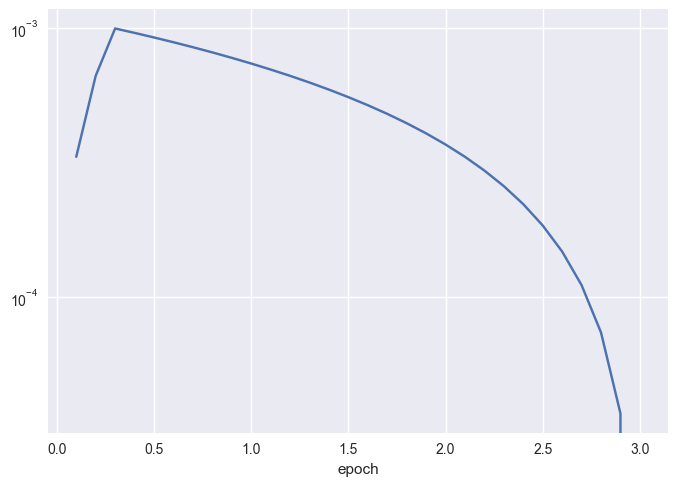

In [19]:
df_hist['learning_rate'].plot(logy=True)


### Perplexity

Perplexity measures how well a language model predicts a text sample. Lower is better

It’s calculated as the average number of bits per word a model needs to represent the same

https://huggingface.co/docs/transformers/perplexity
https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

The **improvement** column, is perplexity decrease

In [28]:
df_res = pd.DataFrame(data)
df_res['len'] = df_res.content.str.len()
df_res = df_res[['before', 'after', 'title',  'len']].set_index('title')
df_res['improvement%'] = (df_res['before'] - df_res['after'])/ df_res['before']
df_res['improvement'] = (df_res['before'] - df_res['after'])
df_res['novel'] = df_res['before'] > 15
df_res['learnable'] = df_res['improvement%'] > 0.02

# We can measure the final score using learnable * novel
# df_res['BS'] = ~df_res['learnable'] | ~df_res['novel']
# Or just absolute perplexity improvement
df_res['BS'] = df_res['improvement'] < .3
df_res = df_res.sort_values('improvement', ascending=False)
df_res

,before,after,len,improvement%,improvement,novel,learnable,BS
title,,,,,,,,
"cicero from ibois, Philippe (2012-06-03).",72.587372,67.744194,13707,0.066722,4.843178,True,True,False
politics is the mind-killer,247.551559,245.826813,3158,0.006967,1.724747,True,False,False
openai board ann,55.808502,54.667923,2991,0.020437,1.140579,True,True,False
How to Catch an AI Liar,28.949860,28.008789,5464,0.032507,0.941071,True,True,False
buzzfeed foi fauci emails 2023,23.309443,22.406410,13640,0.038741,0.903032,True,True,False
Gemini to Q*,11.756384,11.190644,42604,0.048122,0.565740,False,True,False
LK-99-en,14.513845,14.066093,15432,0.030850,0.447752,False,True,False
LK-99-es,11.415018,10.972948,12970,0.038727,0.442070,False,True,False
disney appointment,118.826157,118.420128,3653,0.003417,0.406029,True,False,False


In [26]:
#  df_res.sort_values('improvement%', ascending=False)

In [22]:
print(df_res.to_markdown())

| title                                     |    before |     after |   len |   improvement% |   improvement | novel   | learnable   | BS    |
|:------------------------------------------|----------:|----------:|------:|---------------:|--------------:|:--------|:------------|:------|
| cicero from ibois, Philippe (2012-06-03). |  72.5874  |  67.7442  | 13707 |     0.066722   |     4.84318   | True    | True        | False |
| politics is the mind-killer               | 247.552   | 245.827   |  3158 |     0.00696722 |     1.72475   | True    | False       | False |
| openai board ann                          |  55.8085  |  54.6679  |  2991 |     0.0204374  |     1.14058   | True    | True        | False |
| How to Catch an AI Liar                   |  28.9499  |  28.0088  |  5464 |     0.0325069  |     0.941071  | True    | True        | True  |
| buzzfeed foi fauci emails 2023            |  23.3094  |  22.4064  | 13640 |     0.0387411  |     0.903032  | True    | True        | True  |

# DEBUG

In [23]:
from IPython.display import display, HTML, Markdown
import torch

@torch.no_grad()
def gen(model, inputs, tokenizer, clean=True):
    s = model.generate(
        input_ids=inputs["input_ids"][None, :].to(model.device),
        attention_mask=inputs["attention_mask"][None, :].to(model.device),
        use_cache=False,
        max_new_tokens=100,
        min_new_tokens=100,
        do_sample=False,
        early_stopping=False,
    )
    input_l = inputs["input_ids"].shape[0]
    tokenizer_kwargs=dict(clean_up_tokenization_spaces=clean, skip_special_tokens=clean)
    old = tokenizer.decode(
        s[0, :input_l][-100:], **tokenizer_kwargs
    )
    new = tokenizer.decode(
        s[0, input_l:], **tokenizer_kwargs
    )
    s_old = ""+old.replace('\n', '<br>')
    s_new =  '<b>' + new.replace('\n', '<br>')+ '<br><br><b/>'
    # print(s_old, s_new)
    display(HTML(f"{s_old}{s_new}"))
    # print([old, new])



In [24]:
sample = samples[-1]
s = sample['content']
first_half = s[:len(s)//2]
second_half = s[len(s)//2:]
ds_train = Dataset.from_dict(tokenizer([first_half]))
ds_val = Dataset.from_dict(tokenizer([second_half]))

In [25]:
with model.disable_adapter():
    gen(model, ds_train.with_format('pt')[0], tokenizer)

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.07 GiB. GPU 0 has a total capacty of 10.75 GiB of which 612.62 MiB is free. Including non-PyTorch memory, this process has 10.15 GiB memory in use. Of the allocated memory 9.78 GiB is allocated by PyTorch, and 179.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
gen(model, ds_train.with_format('pt')[0], tokenizer)